## BERT classifier v8: Finding agreement between male and female annotators, looking at offensive words
Trained on balanced data for male annotators in toxic/nontoxic classes, label = toxicity, tested toxicity predictions for toxic comments annotated by men/women.\
Examined frequency of offensive words.

Using BERT code from: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

Adapted BERT for sentiment analysis using code from: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

After training the model will be saved in bert_male_state.bin and can be reused for future runs

Using offensive words list from: https://www.cs.cmu.edu/~biglou/resources/

Correlation methods taken from: https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/

### Before running, check values of:
* file paths
* MAX_LEN
* batch_size
* size
* epochs
* pretrained
* saved_test_set
* seed_val

In [1]:
# Install required libraries
#!conda install -y tensorflow
#!conda install -y pytorch torchvision -c pytorch
#!pip install transformers
#!pip install transformers==3.5.1
#!pip install -U seaborn
#!pip install wordcloud

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import random
import math
import nltk
import datetime
import time
import string
import torch
from torch import nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import logging
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pickle
from wordcloud import WordCloud

# In order to use notebook in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Choose whether to use pretrained model
pretrained = True

In [4]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
# Read files and create dataframe (may need to change path)
toxicity_comments = pd.read_csv('../toxicity_annotated_comments.tsv', sep = '\t', index_col = 0)
toxicity_annotations = pd.read_csv('../toxicity_annotations.tsv',  sep = '\t')
toxicity_demographics = pd.read_csv('../toxicity_worker_demographics.tsv', sep = '\t')
    
# Take a look at data
display (toxicity_comments.head(5))
display (toxicity_annotations.head(5))
display (toxicity_demographics.head(5))

comment  year  logged_in  \
rev_id                                                                        
2232.0   This:NEWLINE_TOKEN:One can make an analogy in ...  2002       True   
4216.0   `NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...  2002       True   
8953.0                           Elected or Electoral? JHK  2002      False   
26547.0  `This is such a fun entry.   DevotchkaNEWLINE_...  2002       True   
28959.0  Please relate the ozone hole to increases in c...  2002       True   

              ns  sample  split  
rev_id                           
2232.0   article  random  train  
4216.0      user  random  train  
8953.0   article  random   test  
26547.0  article  random  train  
28959.0  article  random   test

rev_id  worker_id  toxicity  toxicity_score
0  2232.0        723         0             0.0
1  2232.0       4000         0             0.0
2  2232.0       3989         0             1.0
3  2232.0       3341         0             0.0
4  2232.0       1574         0             1.0

worker_id  gender  english_first_language age_group  education
0         85  female                       0     18-30  bachelors
1       1617  female                       0     45-60  bachelors
2       1394  female                       0       NaN  bachelors
3        311    male                       0     30-45  bachelors
4       1980    male                       0     45-60    masters

In [6]:
# Merge into single DataFrame
toxicity = toxicity_comments.merge(toxicity_annotations, how ='outer', on="rev_id")
toxicity = toxicity.merge(toxicity_demographics, how ='outer', on="worker_id").sort_values(by=['rev_id','worker_id'])

# Remove newline and tab tokens from comments
toxicity['comment'] = toxicity['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxicity['comment'] = toxicity['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

# Remove annotators with 'other' as gender (too few to include in results)
toxicity = toxicity[toxicity['gender']!='other']

# Add binary gender columns
toxicity = pd.concat([toxicity, pd.get_dummies(toxicity.gender).rename(columns = "{}_binary".format)], axis = 1)

# Look at data with new columns
display (toxicity.head(5))

rev_id                                            comment  year  \
3467  2232.0  This: :One can make an analogy in mathematical...  2002   
3039  2232.0  This: :One can make an analogy in mathematical...  2002   
0     2232.0  This: :One can make an analogy in mathematical...  2002   
2600  2232.0  This: :One can make an analogy in mathematical...  2002   
2169  2232.0  This: :One can make an analogy in mathematical...  2002   

      logged_in       ns  sample  split  worker_id  toxicity  toxicity_score  \
3467       True  article  random  train        405         0             1.0   
3039       True  article  random  train        680         0             0.0   
0          True  article  random  train        723         0             0.0   
2600       True  article  random  train        772         0             1.0   
2169       True  article  random  train       1508         0             1.0   

      gender  english_first_language age_group  education  female_binary  \
3467    male                     0.0     30-45    masters              0   
3039    male                     0.0     18-30    masters              0   
0     female                     0.0     30-45  bachelors              1   
2600    male                     0.0     18-30  bachelors              0   
2169  female                     1.0     45-60         hs              1   

      male_binary  
3467            1  
3039            1  
0               0  
2600            1  
2169            0

In [7]:
# Separate comments into categories
very_toxic = toxicity[toxicity.toxicity_score == -2.0]
toxic = toxicity[toxicity.toxicity_score == -1.0]
nontoxic = toxicity[toxicity.toxicity == 0]

# Filter for male annotated data
male_toxic = toxic[toxic.male_binary == 1]
male_very_toxic = very_toxic[very_toxic.male_binary == 1]
male_nontoxic = nontoxic[nontoxic.male_binary == 1]

# Find smallest toxic dataset
size = min(male_toxic.shape[0],male_very_toxic.shape[0])
print("smallest:",size)

# Manually choose size if necessary
# size = 2000

# Split into train and test sets
test_size = math.floor(size*0.2)
train_size = math.ceil(size*0.8)

# Create toxic test dataset and drop from dataframes so not also chosen for training
male_toxic_test = male_toxic.sample(n=test_size)
male_toxic = male_toxic.drop(male_toxic_test.index)
male_vtoxic_test = male_very_toxic.sample(n=test_size)
male_very_toxic = male_very_toxic.drop(male_vtoxic_test.index)
male_test_data = pd.concat([male_toxic_test,male_vtoxic_test])
male_test_data = male_test_data.sample(frac=1)
print("test size:",male_test_data.shape[0])

# Training data composed of equal proportions of male toxic/nontoxic
male_data = pd.concat([male_toxic.sample(train_size),male_very_toxic.sample(train_size),male_nontoxic.sample(train_size*2)])
male_data = male_data.sample(frac=1)
print("train size:",male_data.shape[0])

smallest: 21863
test size: 8744
train size: 69964


In [8]:
# Take a look at training data
display (male_data.head(5))

rev_id                                            comment  year  \
910183   350213469.0    ==Iranian-Americans==  Hey, don't really edi...  2010   
1569238  372036398.0        == Harrassment on my own talk page == Ari:   2010   
303406   261487636.0  ` :::::Whether one agrees or disagrees with th...  2009   
45505     22455813.0  `Hi Paul  Given your previous edits of this ar...  2005   
1563061  451242777.0    :: The references you provided does not subs...  2011   

         logged_in       ns   sample  split  worker_id  toxicity  \
910183        True  article   random  train        412         0   
1569238       True     user  blocked  train       1503         1   
303406        True     user   random  train       1036         0   
45505        False  article  blocked   test        292         0   
1563061       True  article  blocked   test       2316         0   

         toxicity_score gender  english_first_language age_group  education  \
910183              1.0   male                     0.0     30-45  bachelors   
1569238            -1.0   male                     0.0     18-30  bachelors   
303406              0.0   male                     0.0     18-30       some   
45505               1.0   male                     0.0     45-60  bachelors   
1563061             0.0   male                     0.0  Under 18         hs   

         female_binary  male_binary  
910183               0            1  
1569238              0            1  
303406               0            1  
45505                0            1  
1563061              0            1

In [9]:
# Try to use gpu
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070


In [10]:
# Extract relevant information from training data (comment and toxicity of comment)
comments = male_data.comment.values
labels = male_data.toxicity.values

In [11]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


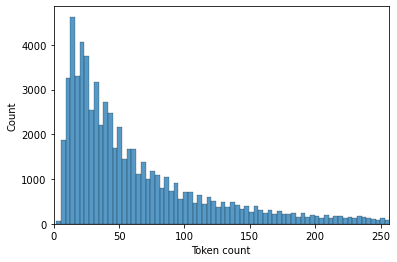

In [12]:
# Plot the distribution of sequence lengths to optimize the maximum sequence length used.  Large sequence lengths use a lot of GPU memory.

plot_dist = True

if plot_dist:

    token_lens = []

    for txt in comments:
      tokens = tokenizer.encode(txt, max_length=512, truncation=True)
      token_lens.append(len(tokens))

    sns.histplot(token_lens)
    plt.xlim([0, 256]);
    plt.xlabel('Token count');

In [13]:
# Limit the length of the sequence in tokens to control memory usage
MAX_LEN=100

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# # Print sentence 0, now as a list of IDs.
print('Original: ', comments[0])
print('Token IDs:', input_ids[0])

Original:    ==Iranian-Americans==  Hey, don't really edit anymore much, but there is also a campaign to write in Iranian-Americans at Iranican.com. Anyone interested can add this, or not.   
Token IDs: tensor([  101,  1027,  1027,  7726,  1011,  4841,  1027,  1027,  4931,  1010,
         2123,  1005,  1056,  2428, 10086,  4902,  2172,  1010,  2021,  2045,
         2003,  2036,  1037,  3049,  2000,  4339,  1999,  7726,  1011,  4841,
         2012,  4238,  5555,  2078,  1012,  4012,  1012,  3087,  4699,  2064,
         5587,  2023,  1010,  2030,  2025,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [14]:
# Examining tokenization
print("vocab size:",tokenizer.vocab_size)

vocab size: 30522


In [15]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

62,967 training samples
6,997 validation samples


In [16]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size
)

In [17]:
logging.set_verbosity_error() # set to warning to show warnings

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
#model.cpu()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [19]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Defining loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [20]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
# Defining training epoch of BERT model
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    
  # Measure how long the training epoch takes.
  t0 = time.time()
    
  # Put the model into training mode
  model = model.train()

  losses = []
  correct_predictions = 0
  
  # For each batch of training data...
  for step, batch in enumerate(data_loader):
    
    # Progress update every few batches.
    if step % 200 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
              
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(data_loader), elapsed))
    
    # Unpack this training batch from our dataloader. 
    # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    targets = batch[2].type(torch.LongTensor).to(device)
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs[0], dim=1)
    loss = loss_fn(outputs[0], targets)

    correct_predictions += torch.sum(preds == targets)
    
    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
    losses.append(loss.item())

    # Perform a backward pass to calculate the gradients.
    loss.backward()
    
    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Update parameters and take a step using the computed gradient.
    optimizer.step()
    
    # Update the learning rate.
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
  model = model.eval()

  losses = []
  correct_predictions = 0

  # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training).
  with torch.no_grad():
    for batch in data_loader:
        
      # Unpack this validation batch from our dataloader. 
      # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      targets = batch[2].type(torch.LongTensor).to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs[0], dim=1)

      loss = loss_fn(outputs[0], targets)

      correct_predictions += torch.sum(preds == targets)
    
      # Accumulate the validation loss
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
%%time

history = defaultdict(list)
best_accuracy = 0

if pretrained:
    model.load_state_dict(torch.load('bert_male_state.bin'))
    model = model.to(device)
else:
    # Performing training and validation for each epoch
    # Report loss and accuracy
    for epoch in range(epochs):

        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_dataloader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        train_size
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        validation_dataloader,
        loss_fn, 
        device, 
        val_size
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'bert_male_state.bin')
            best_accuracy = val_acc

    # Plot the performance of the model over all epochs
    plt.figure(0)
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')

    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    
    plt.figure(1)
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')

    plt.title('Training history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    

CPU times: user 110 ms, sys: 88 ms, total: 198 ms
Wall time: 197 ms


Using male toxic test data
Number of test sentences: 8,744

Predicting labels for 8,744 test sentences...
    DONE.
Total F1: 0.912
Accuracy: 0.84


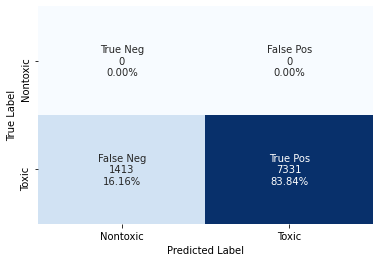

In [24]:
# Evaluating test set

# Initialising
accuracies = []

# Get previous test data if pretrained
if pretrained:
    with open("male_test.data", 'rb') as file:
        df = pickle.load(file)
    file.close()
else:
    df = male_test_data
    with open("male_test.data", 'wb') as file:
        pickle.dump(df,file)
    file.close()
    
df = df.sample(frac=1)
male_df = df
print('Using male toxic test data')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

male_true_pos = []
male_false_neg = []

# Add predictions to relevant lists for later analysis
for i in range(len(flat_predictions)):
    if flat_predictions[i] == 1:
        male_true_pos.append(comments[i])
    else:
        male_false_neg.append(comments[i])

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

Using male test data (toxic and nontoxic)
Number of test sentences: 17,488

Predicting labels for 17,488 test sentences...
    DONE.
Total F1: 0.855
Accuracy: 0.86


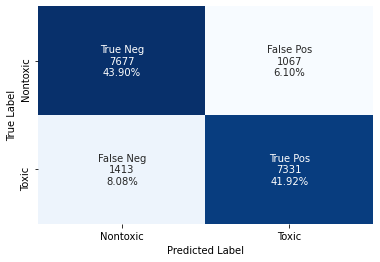

In [25]:
# Analysing all male test data for later use with correlations

# Create balanced test data
male_nontoxic_test = male_nontoxic[~male_nontoxic.apply(tuple,1).isin(male_data.apply(tuple,1))]
male_nontoxic_test = male_nontoxic_test.sample(n=male_df.shape[0])
df = pd.concat([male_df,male_nontoxic_test])
df = df.sample(frac=1)

print('Using male test data (toxic and nontoxic)')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

In [26]:
# Count number of offensive words in comment

# List of offensive words taken from: https://www.cs.cmu.edu/~biglou/resources/
file = open('bad-words.txt','r')
offensive_words = file.read().splitlines()
offensive_words = [word.replace(" ","") for word in offensive_words]
file.close()

acceptable = ['','adult','africa','alla','allah','african','arab','arabs','asian','american','angry','australian','baptist','bible','bigger','black','blacks','burn','canadian','catholic','cemetery','catholics',"children's",'chinese','christian','church','cigarette','cocaine','cocktail','color','ecstacy','ethiopian','european','faith','fear','filipina','filipino','fire','funeral','german','gin','girls','heroin','israel','israeli',"israel's",'italiano','japanese','jew','jewish','joint','kid','latin','lsd','lucifer','marijuana','meth','mexican','mormon','muslim','narcotic','nigerian','nigerians','palestinian','poverty','pot','protestant','rabbi','vatican','welfare','whites',"women's"]
for word in acceptable:
    offensive_words.remove(word)

def offensive_count(comment):
    temp_dict = {}
    words = nltk.word_tokenize(comment)
    for word in words:
        if word in offensive_words:
            if word in temp_dict:
                temp_dict[word] += 1
            else:
                temp_dict[word] = 1
    return temp_dict, len(words)

True Labels


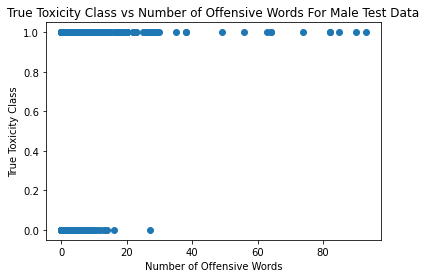

Number of Offensive Words: mean=0.900 stdv=2.702
True Toxicity Class: mean=0.499 stdv=0.500
Pearsons correlation: 0.249
Spearmans correlation: 0.482
Predicted Labels


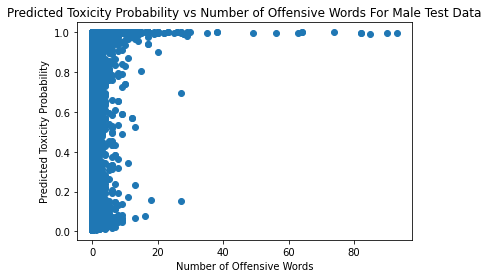

Number of Offensive Words: mean=0.900 stdv=2.702
Predicted Toxicity Class: mean=0.487 stdv=0.449
Pearsons correlation: 0.283
Spearmans correlation: 0.581


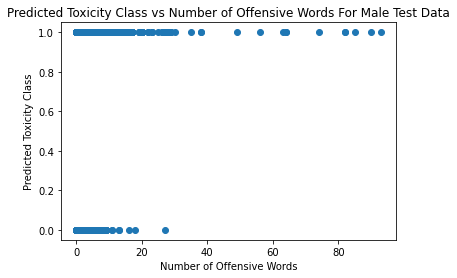

Number of Offensive Words: mean=0.900 stdv=2.702
Predicted Toxicity Class: mean=0.479 stdv=0.500
Pearsons correlation: 0.265
Spearmans correlation: 0.523


In [27]:
# Evaluating correlations between number of toxic words and true/predicted labels

from numpy import mean
from numpy import std
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# True Labels
print("True Labels")
x = []
for comment in comments:
    temp_dict, _ = offensive_count(comment)
    num = sum(temp_dict.values())
    x.append(num)
    
# Removing outliers
outliers = [i for i in range(len(x)) if x[i]>100]
x = [x[i] for i in range(len(x)) if i not in outliers]    
    
y = [flat_true_labels[i] for i in range(len(flat_true_labels)) if i not in outliers]

plt.scatter(x, y)
plt.xlabel('Number of Offensive Words')  
plt.ylabel('True Toxicity Class')   
plt.title("True Toxicity Class vs Number of Offensive Words For Male Test Data") 
plt.show()

# calculate statistics
print('Number of Offensive Words: mean=%.3f stdv=%.3f' % (mean(x), std(x)))
print('True Toxicity Class: mean=%.3f stdv=%.3f' % (mean(y), std(y)))

# calculate Pearson's correlation
corr, _ = pearsonr(x,y)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(x,y)
print('Spearmans correlation: %.3f' % corr)

# Predicted Labels
print("Predicted Labels")

y = [torch.softmax(torch.from_numpy(flat_pred[i]), dim=0)[1] for i in range(len(flat_pred)) if i not in outliers]

plt.scatter(x, y)
plt.xlabel('Number of Offensive Words')  
plt.ylabel('Predicted Toxicity Probability')   
plt.title("Predicted Toxicity Probability vs Number of Offensive Words For Male Test Data") 
plt.show()

# calculate statistics
print('Number of Offensive Words: mean=%.3f stdv=%.3f' % (mean(x), std(x)))
print('Predicted Toxicity Class: mean=%.3f stdv=%.3f' % (mean(y), std(y)))

# calculate Pearson's correlation
corr, _ = pearsonr(x,y)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(x,y)
print('Spearmans correlation: %.3f' % corr)

y = [flat_predictions[i] for i in range(len(flat_predictions)) if i not in outliers]

plt.scatter(x, y)
plt.xlabel('Number of Offensive Words')  
plt.ylabel('Predicted Toxicity Class')   
plt.title("Predicted Toxicity Class vs Number of Offensive Words For Male Test Data") 
plt.show()

# calculate statistics
print('Number of Offensive Words: mean=%.3f stdv=%.3f' % (mean(x), std(x)))
print('Predicted Toxicity Class: mean=%.3f stdv=%.3f' % (mean(y), std(y)))

# calculate Pearson's correlation
corr, _ = pearsonr(x,y)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(x,y)
print('Spearmans correlation: %.3f' % corr)


In [28]:
# Creating and evaluating female toxic test set

# Choose whether to use saved data
saved_test_set = True

# Load saved data or create new test set
if saved_test_set:
    with open("female_test.data", 'rb') as file:
        df = pickle.load(file)
    file.close()
else:
    # Create balanced test data (between toxic and very toxic)
    female_toxic = toxic[toxic.female_binary == 1]
    female_very_toxic = very_toxic[very_toxic.female_binary == 1]
    print(test_size)
    print(female_toxic.shape[0])
    print(female_very_toxic.shape[0])
    test_size = min(test_size, female_toxic.shape[0],female_very_toxic.shape[0])
    female_toxic_test = female_toxic.sample(n=test_size)
    female_vtoxic_test = female_very_toxic.sample(n=test_size)
    df = pd.concat([female_toxic_test,female_vtoxic_test])

Using female toxic test data
Number of test sentences: 5,630

Predicting labels for 5,630 test sentences...
    DONE.
Total F1: 0.870
Accuracy: 0.77


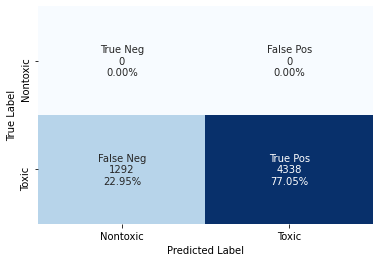

In [29]:
# Evaluating test set

# Initialising
accuracies = []

df = df.sample(frac=1)
female_df = df
print('Using female toxic test data')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

female_true_pos = []
female_false_neg = []

# Add predictions to relevant lists for later analysis
for i in range(len(flat_predictions)):
    if flat_predictions[i] == 1:
        female_true_pos.append(comments[i])
    else:
        female_false_neg.append(comments[i])

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

Using female test data (toxic and nontoxic)
Number of test sentences: 11,260

Predicting labels for 11,260 test sentences...
    DONE.
Total F1: 0.811
Accuracy: 0.82


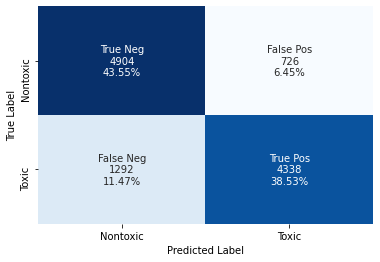

In [30]:
# Analysing all female test data for later use with correlations

# Create balanced test data
female_nontoxic = nontoxic[nontoxic.female_binary==1]
female_nontoxic_test = female_nontoxic.sample(n=female_df.shape[0])
df = pd.concat([female_df,female_nontoxic_test])
df = df.sample(frac=1)

print('Using female test data (toxic and nontoxic)')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

True Labels


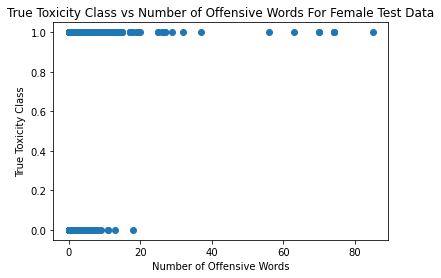

Number of Offensive Words: mean=0.810 stdv=2.581
True Toxicity Class: mean=0.499 stdv=0.500
Pearsons correlation: 0.230
Spearmans correlation: 0.438
Predicted Labels


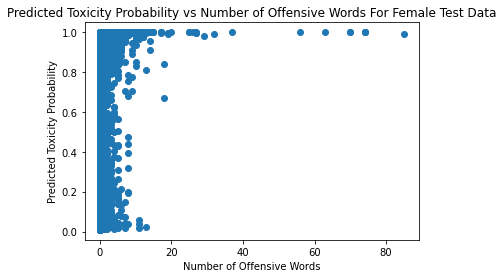

Number of Offensive Words: mean=0.810 stdv=2.581
Predicted Toxicity Class: mean=0.460 stdv=0.443
Pearsons correlation: 0.279
Spearmans correlation: 0.562


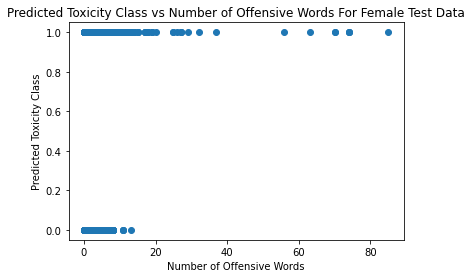

Number of Offensive Words: mean=0.810 stdv=2.581
Predicted Toxicity Class: mean=0.449 stdv=0.497
Pearsons correlation: 0.259
Spearmans correlation: 0.503


In [31]:
# Evaluating correlations between number of toxic words and true/predicted labels

# True Labels
print("True Labels")
x = []
for comment in comments:
    temp_dict, _ = offensive_count(comment)
    num = sum(temp_dict.values())
    x.append(num)
    
# Removing outliers
outliers = [i for i in range(len(x)) if x[i]>100]
x = [x[i] for i in range(len(x)) if i not in outliers]    
    
y = [flat_true_labels[i] for i in range(len(flat_true_labels)) if i not in outliers]

plt.scatter(x, y)
plt.xlabel('Number of Offensive Words')  
plt.ylabel('True Toxicity Class')   
plt.title("True Toxicity Class vs Number of Offensive Words For Female Test Data") 
plt.show()

# calculate statistics
print('Number of Offensive Words: mean=%.3f stdv=%.3f' % (mean(x), std(x)))
print('True Toxicity Class: mean=%.3f stdv=%.3f' % (mean(y), std(y)))

# calculate Pearson's correlation
corr, _ = pearsonr(x,y)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(x,y)
print('Spearmans correlation: %.3f' % corr)

# Predicted Labels
print("Predicted Labels")

y = [torch.softmax(torch.from_numpy(flat_pred[i]), dim=0)[1] for i in range(len(flat_pred)) if i not in outliers]

plt.scatter(x, y)
plt.xlabel('Number of Offensive Words')  
plt.ylabel('Predicted Toxicity Probability')   
plt.title("Predicted Toxicity Probability vs Number of Offensive Words For Female Test Data") 
plt.show()

# calculate statistics
print('Number of Offensive Words: mean=%.3f stdv=%.3f' % (mean(x), std(x)))
print('Predicted Toxicity Class: mean=%.3f stdv=%.3f' % (mean(y), std(y)))

# calculate Pearson's correlation
corr, _ = pearsonr(x,y)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(x,y)
print('Spearmans correlation: %.3f' % corr)

y = [flat_predictions[i] for i in range(len(flat_predictions)) if i not in outliers]

plt.scatter(x, y)
plt.xlabel('Number of Offensive Words')  
plt.ylabel('Predicted Toxicity Class')   
plt.title("Predicted Toxicity Class vs Number of Offensive Words For Female Test Data") 
plt.show()

# calculate statistics
print('Number of Offensive Words: mean=%.3f stdv=%.3f' % (mean(x), std(x)))
print('Predicted Toxicity Class: mean=%.3f stdv=%.3f' % (mean(y), std(y)))

# calculate Pearson's correlation
corr, _ = pearsonr(x,y)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(x,y)
print('Spearmans correlation: %.3f' % corr)


In [32]:
# Removing punctuation and converting capital letters to lowercase
male_df['comment'] = male_df['comment'].str.translate(str.maketrans('', '', string.punctuation))
male_df['comment'] = male_df['comment'].str.lower()
female_df['comment'] = female_df['comment'].str.translate(str.maketrans('', '', string.punctuation))
female_df['comment'] = female_df['comment'].str.lower()

# Extract necessary information
male_comments = male_df.comment.values
female_comments = female_df.comment.values
male_scores = male_df.toxicity_score.values
female_scores = female_df.toxicity_score.values

In [33]:
# Analyse counts of toxic words in test data

# Initialise dicts for analysis of different groups
male_toxic_dict = {}
male_toxic_distr = {}
male_toxic_norm_distr = {}
male_vtoxic_dict = {}
male_vtoxic_distr = {}
male_vtoxic_norm_distr = {}
female_toxic_dict = {}
female_toxic_distr = {}
female_toxic_norm_distr = {}
female_vtoxic_dict = {}
female_vtoxic_distr = {}
female_vtoxic_norm_distr = {}

for i in range(len(male_comments)):
    temp_dict, num_words = offensive_count(male_comments[i])
    # Sort into dicts according to toxicity score
    if male_scores[i] == -1:
        # Store number of offensive words in comment
        num = sum(temp_dict.values())
        if num in male_toxic_distr:
            male_toxic_distr[num] += 1
        else:
            male_toxic_distr[num] = 1
        # Store number of offensive words normalised by length of comment
        if num_words != 0:
            normalised = round(num/num_words,2)
            if normalised in male_toxic_norm_distr:
                male_toxic_norm_distr[normalised] += 1
            else:
                male_toxic_norm_distr[normalised] = 1
        # Store which words were in comment
        for key in temp_dict.keys():
            if key in male_toxic_dict:
                male_toxic_dict[key] += temp_dict[key]
            else:
                male_toxic_dict[key] = temp_dict[key]
    else:
        # Store number of offensive words in comment
        num = sum(temp_dict.values())
        if num in male_vtoxic_distr:
            male_vtoxic_distr[num] += 1
        else:
            male_vtoxic_distr[num] = 1
        # Store number of offensive words normalised by length of comment
        if num_words != 0:
            normalised = round(num/num_words,2)
            if normalised in male_vtoxic_norm_distr:
                male_vtoxic_norm_distr[normalised] += 1
            else:
                male_vtoxic_norm_distr[normalised] = 1
        # Store which words were in comment
        for key in temp_dict.keys():
            if key in male_vtoxic_dict:
                male_vtoxic_dict[key] += temp_dict[key]
            else:
                male_vtoxic_dict[key] = temp_dict[key]

for i in range(len(female_comments)):
    temp_dict, num_words = offensive_count(female_comments[i])
    # Sort into dicts according to toxicity score
    if female_scores[i] == -1:
        # Store number of offensive words in comment
        num = sum(temp_dict.values())
        if num in female_toxic_distr:
            female_toxic_distr[num] += 1
        else:
            female_toxic_distr[num] = 1
        # Store number of offensive words normalised by length of comment
        if num_words != 0:
            normalised = round(num/num_words,2)
            if normalised in female_toxic_norm_distr:
                female_toxic_norm_distr[normalised] += 1
            else:
                female_toxic_norm_distr[normalised] = 1
        # Store which words were in comment
        for key in temp_dict.keys():
            if key in female_toxic_dict:
                female_toxic_dict[key] += temp_dict[key]
            else:
                female_toxic_dict[key] = temp_dict[key]
    else:
        # Store number of offensive words in comment
        num = sum(temp_dict.values())
        if num in female_vtoxic_distr:
            female_vtoxic_distr[num] += 1
        else:
            female_vtoxic_distr[num] = 1
        # Store number of offensive words normalised by length of comment
        if num_words != 0:
            normalised = round(num/num_words,2)
            if normalised in female_vtoxic_norm_distr:
                female_vtoxic_norm_distr[normalised] += 1
            else:
                female_vtoxic_norm_distr[normalised] = 1
        # Store which words were in comment
        for key in temp_dict.keys():
            if key in female_vtoxic_dict:
                female_vtoxic_dict[key] += temp_dict[key]
            else:
                female_vtoxic_dict[key] = temp_dict[key]

Wordcloud of offensive words in male toxic test set


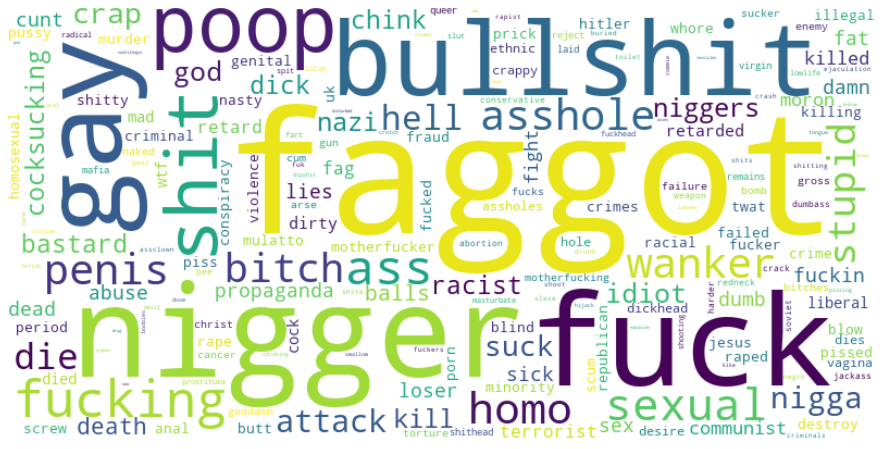

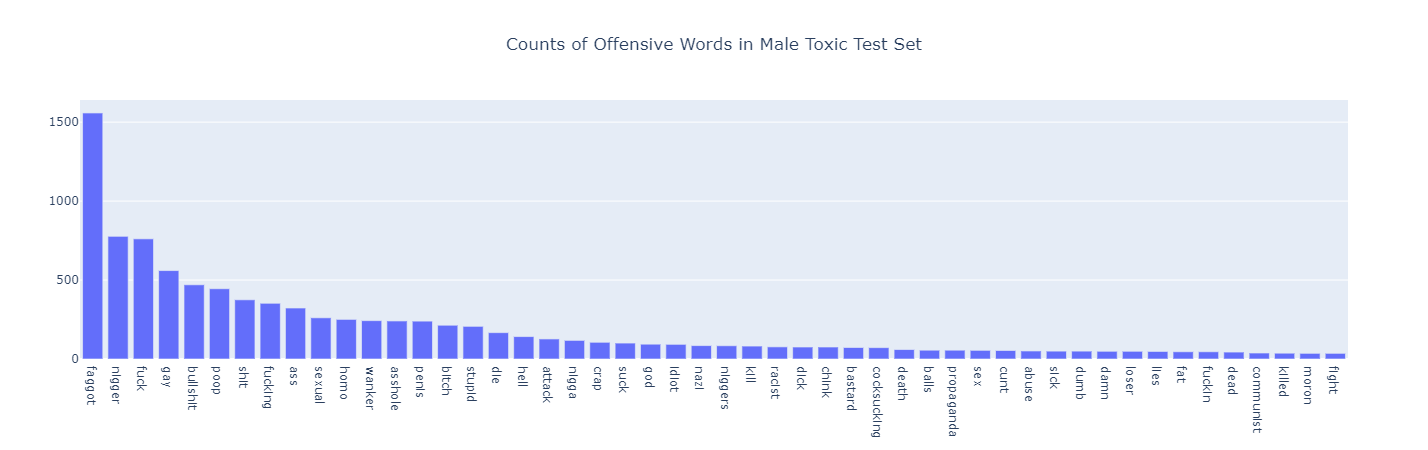

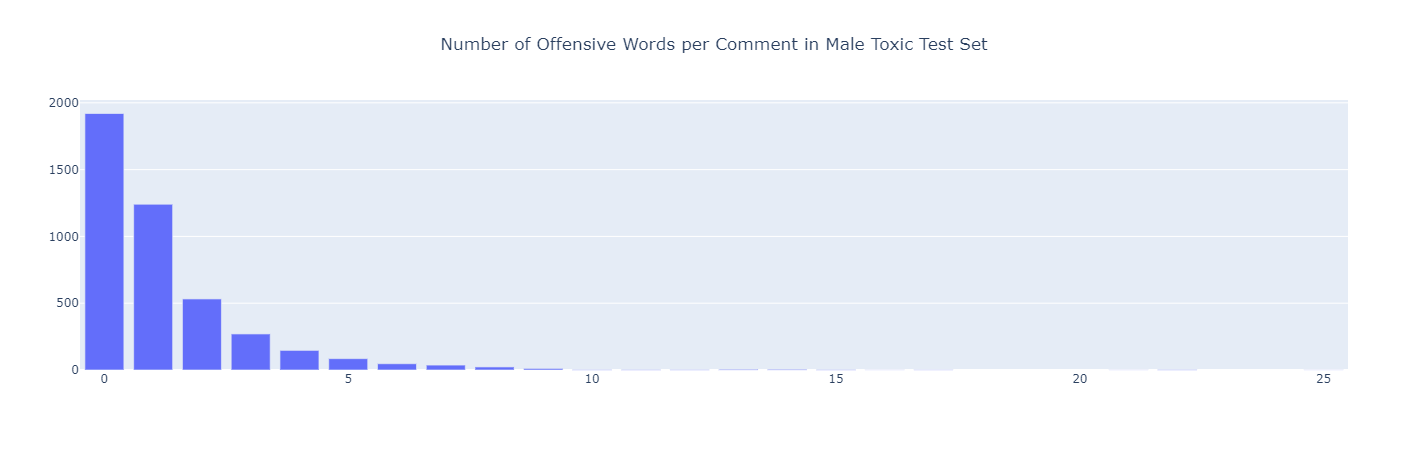

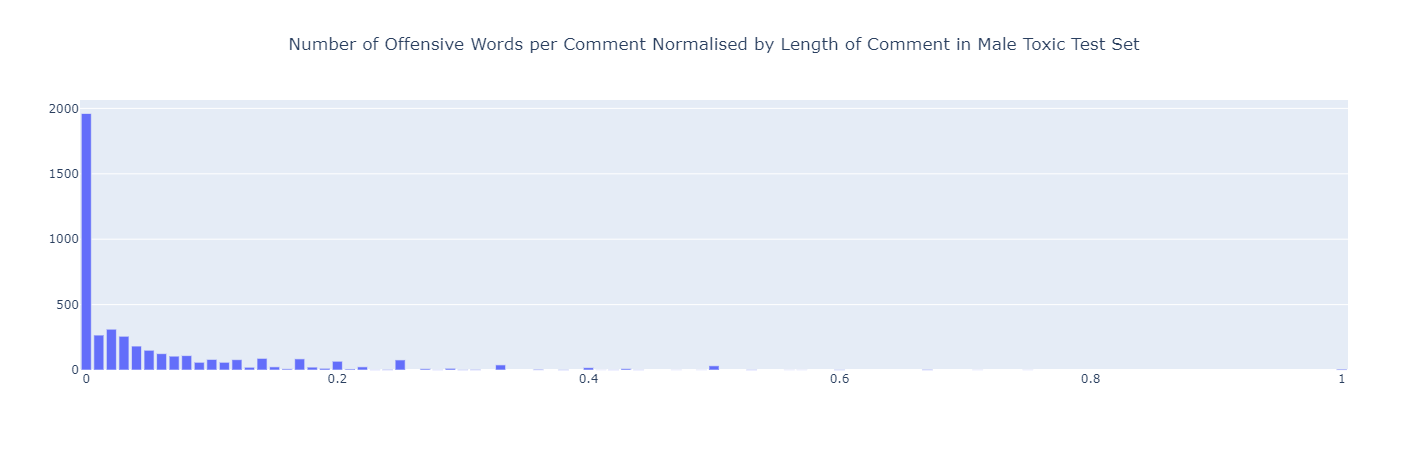

In [34]:
# Visualise results of offensive word analysis for male toxic test data

print("Wordcloud of offensive words in male toxic test set")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(male_toxic_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

male_toxic_dict = dict(sorted(male_toxic_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(male_toxic_dict.keys())[:50]
male_toxic_dict = {key:value for key, value in male_toxic_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(male_toxic_dict.keys()), y=list(male_toxic_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Male Toxic Test Set", title_x=0.5)
fig.show()

male_toxic_distr = dict(sorted(male_toxic_distr.items(), key=lambda item: item[1],reverse = True))
male_toxic_distr = {key:value for key, value in male_toxic_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(male_toxic_distr.keys()), y=list(male_toxic_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Male Toxic Test Set", title_x=0.5)
fig.show()

male_toxic_norm_distr = dict(sorted(male_toxic_norm_distr.items(), key=lambda item: item[1],reverse = True))
male_toxic_norm_distr = {key:value for key, value in male_toxic_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(male_toxic_norm_distr.keys()), y=list(male_toxic_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Male Toxic Test Set", title_x=0.5)
fig.show()


Wordcloud of offensive words in male very toxic test set


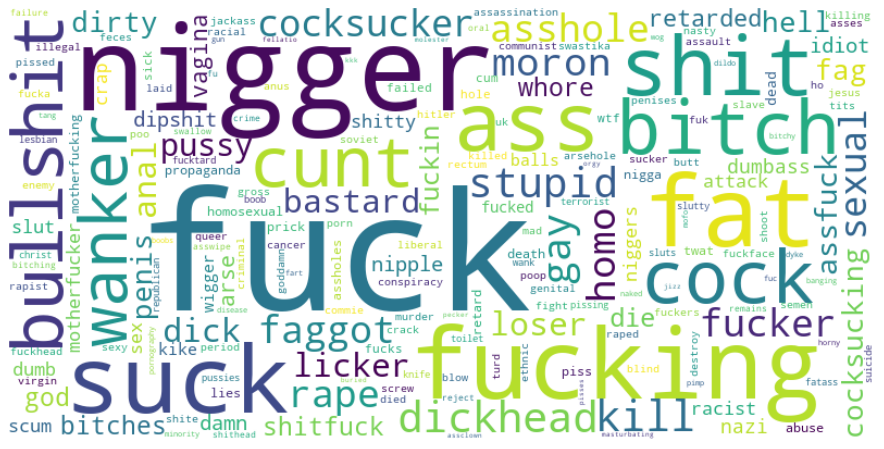

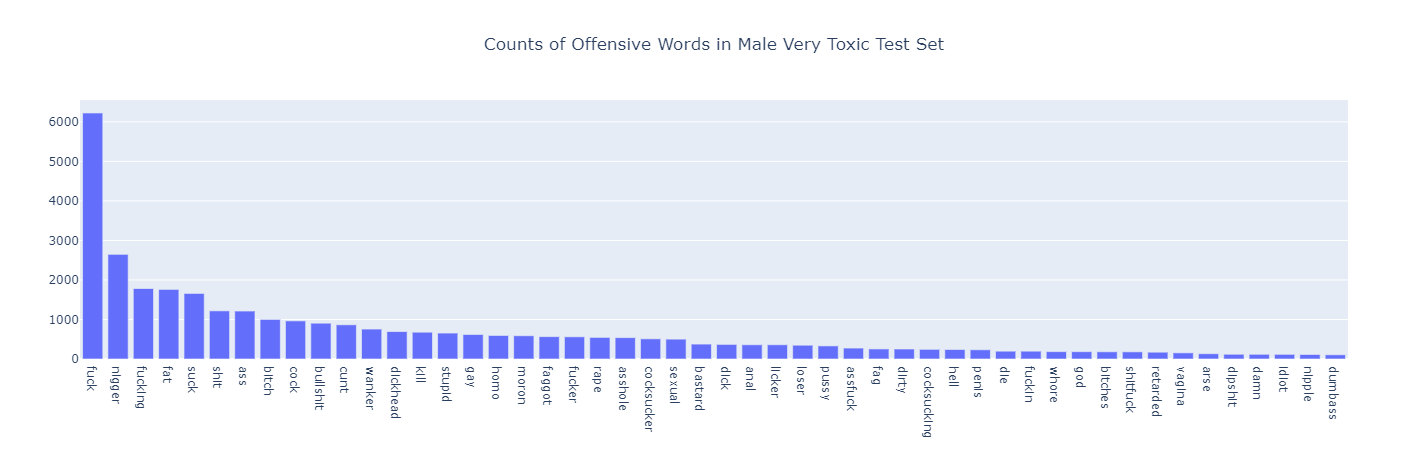

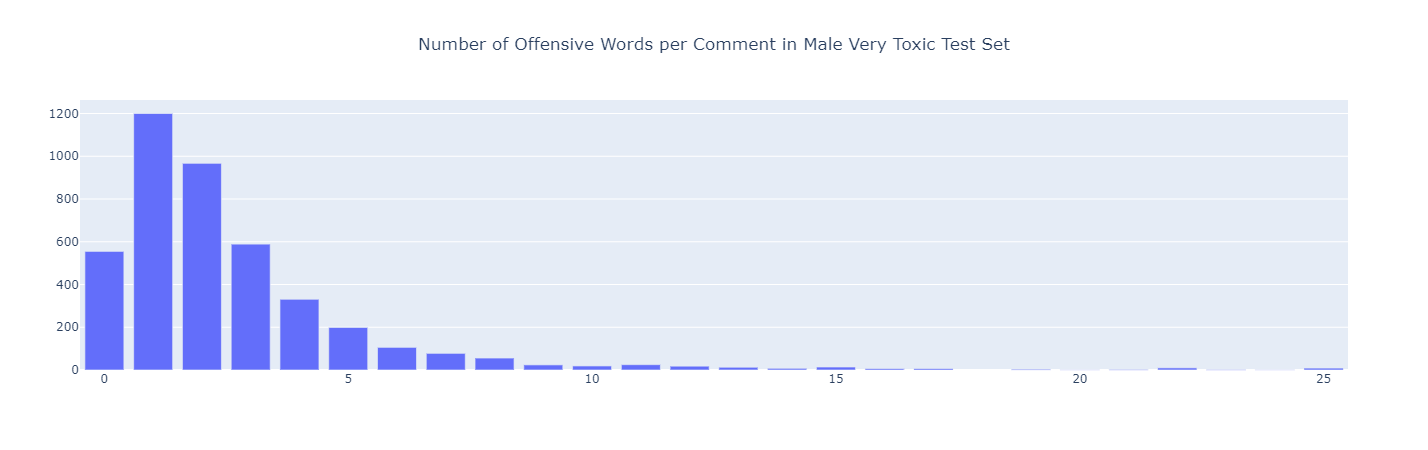

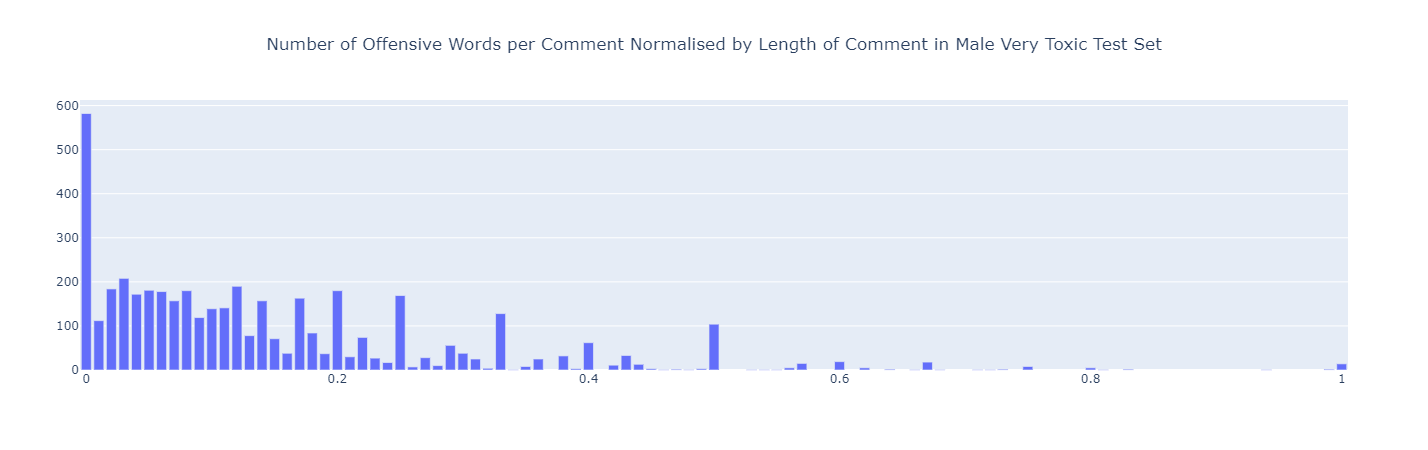

In [35]:
# Visualise results of offensive word analysis for male very toxic test data

print("Wordcloud of offensive words in male very toxic test set")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(male_vtoxic_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

male_vtoxic_dict = dict(sorted(male_vtoxic_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(male_vtoxic_dict.keys())[:50]
male_vtoxic_dict = {key:value for key, value in male_vtoxic_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(male_vtoxic_dict.keys()), y=list(male_vtoxic_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Male Very Toxic Test Set", title_x=0.5)
fig.show()

male_vtoxic_distr = dict(sorted(male_vtoxic_distr.items(), key=lambda item: item[1],reverse = True))
male_vtoxic_distr = {key:value for key, value in male_vtoxic_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(male_vtoxic_distr.keys()), y=list(male_vtoxic_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Male Very Toxic Test Set", title_x=0.5)
fig.show()

male_vtoxic_norm_distr = dict(sorted(male_vtoxic_norm_distr.items(), key=lambda item: item[1],reverse = True))
male_vtoxic_norm_distr = {key:value for key, value in male_vtoxic_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(male_vtoxic_norm_distr.keys()), y=list(male_vtoxic_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Male Very Toxic Test Set", title_x=0.5)
fig.show()


Wordcloud of offensive words in female toxic test set


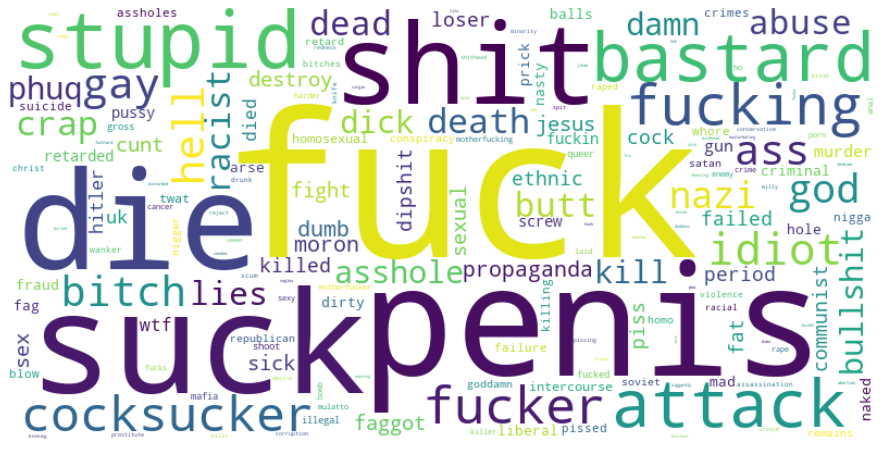

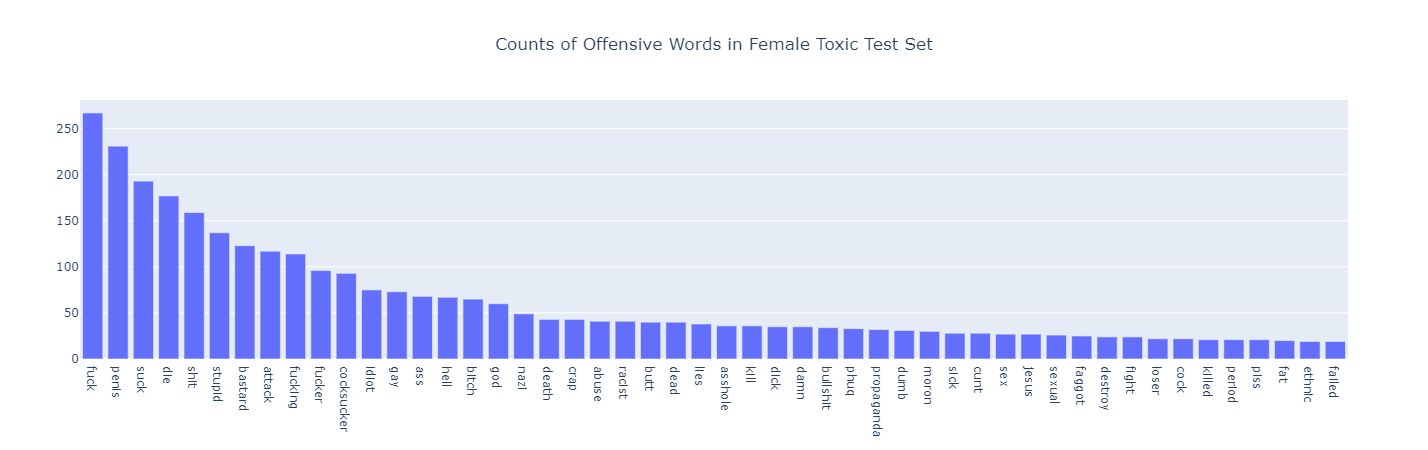

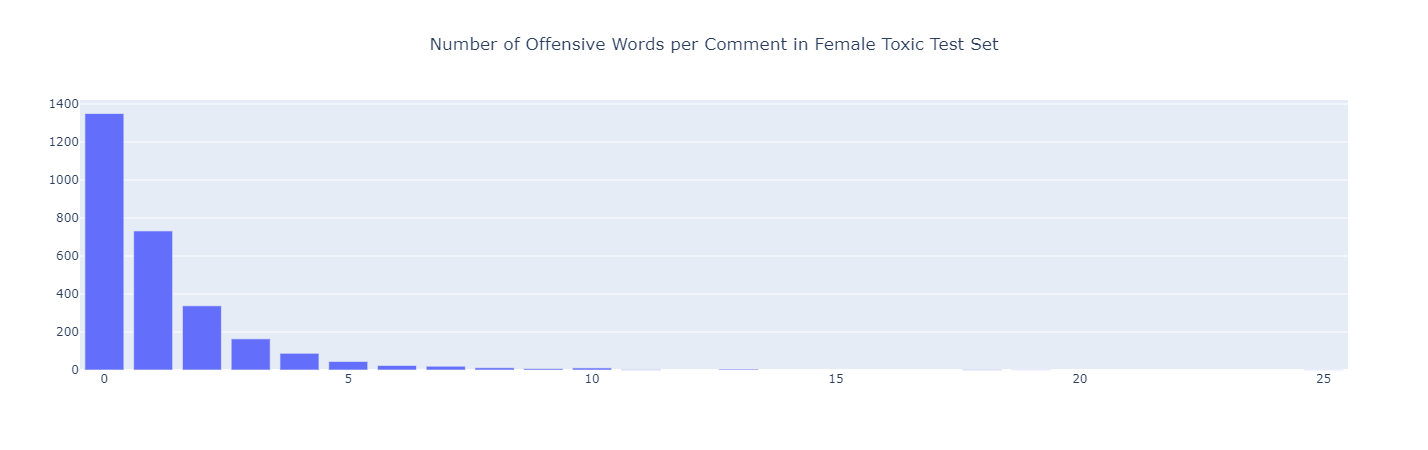

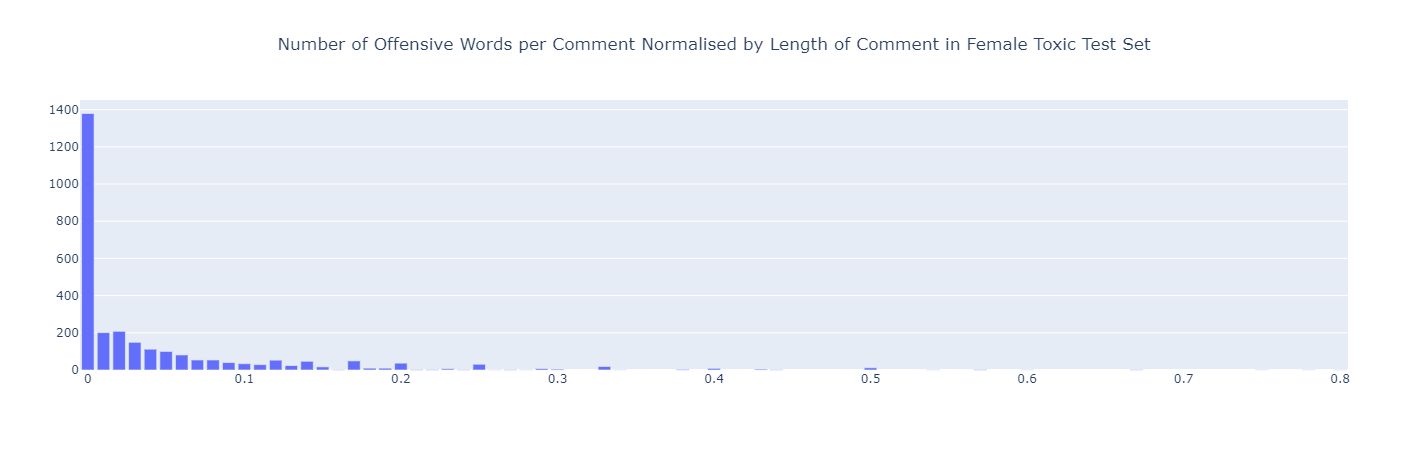

In [36]:
# Visualise results of offensive word analysis for female toxic test data

print("Wordcloud of offensive words in female toxic test set")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(female_toxic_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

female_toxic_dict = dict(sorted(female_toxic_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(female_toxic_dict.keys())[:50]
female_toxic_dict = {key:value for key, value in female_toxic_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(female_toxic_dict.keys()), y=list(female_toxic_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Female Toxic Test Set", title_x=0.5)
fig.show()

female_toxic_distr = dict(sorted(female_toxic_distr.items(), key=lambda item: item[1],reverse = True))
female_toxic_distr = {key:value for key, value in female_toxic_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(female_toxic_distr.keys()), y=list(female_toxic_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Female Toxic Test Set", title_x=0.5)
fig.show()

female_toxic_norm_distr = dict(sorted(female_toxic_norm_distr.items(), key=lambda item: item[1],reverse = True))
female_toxic_norm_distr = {key:value for key, value in female_toxic_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(female_toxic_norm_distr.keys()), y=list(female_toxic_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Female Toxic Test Set", title_x=0.5)
fig.show()


Wordcloud of offensive words in female very toxic test set


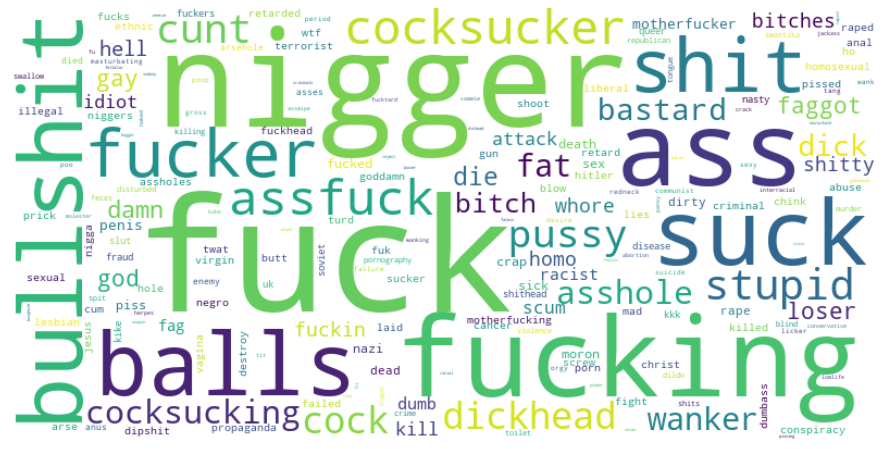

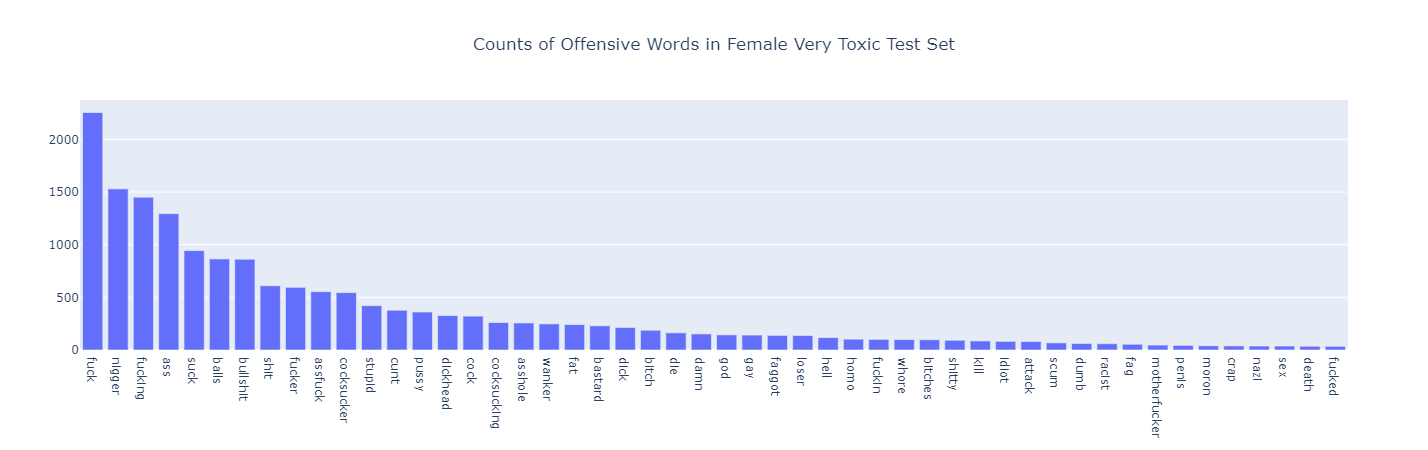

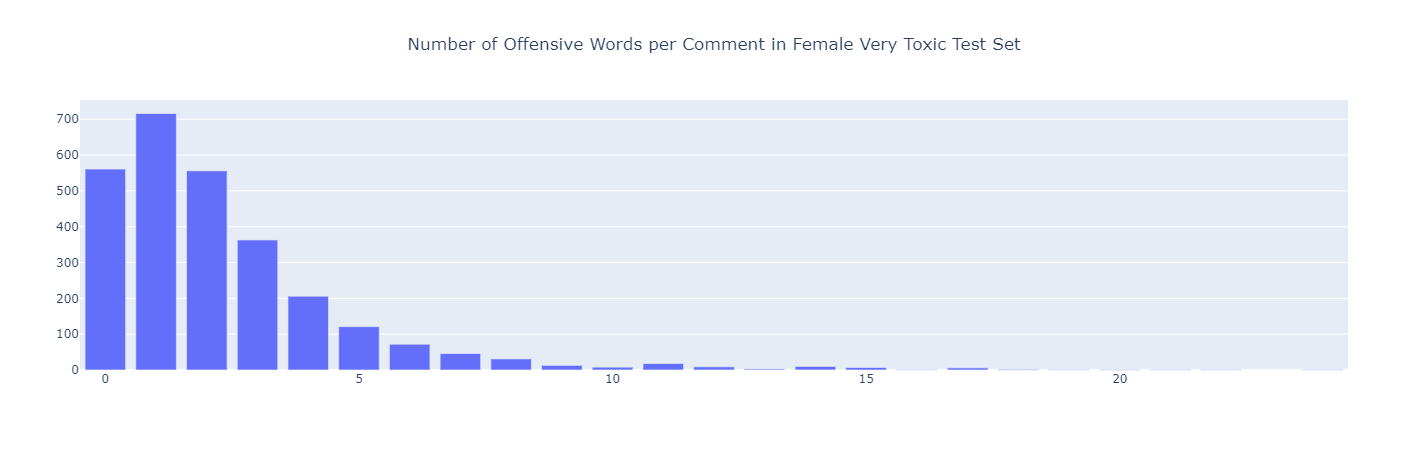

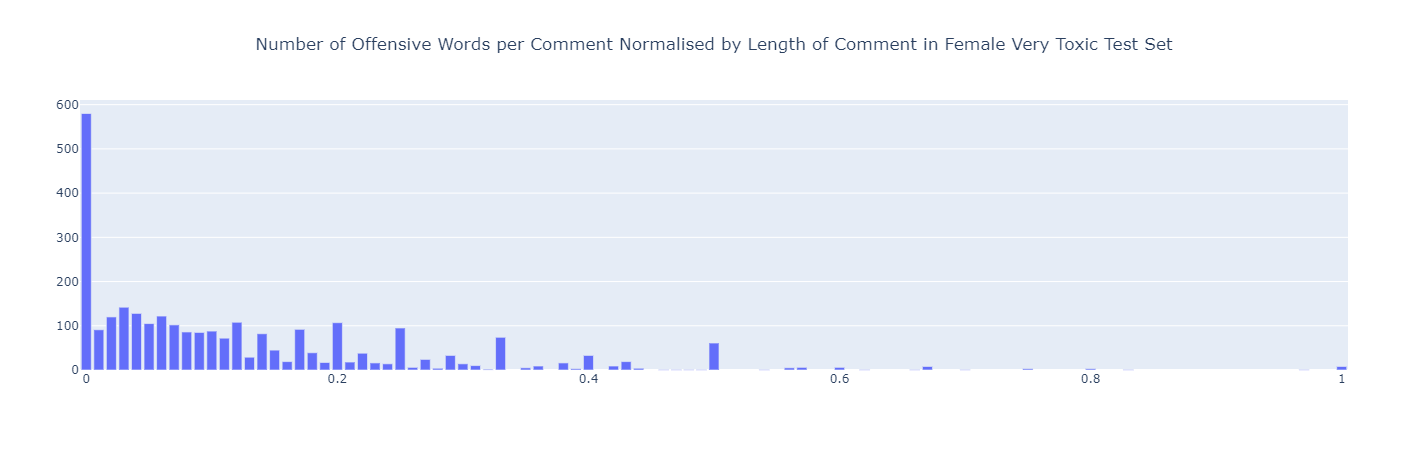

In [37]:
# Visualise results of offensive word analysis for female very toxic test data

print("Wordcloud of offensive words in female very toxic test set")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(female_vtoxic_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

female_vtoxic_dict = dict(sorted(female_vtoxic_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(female_vtoxic_dict.keys())[:50]
female_vtoxic_dict = {key:value for key, value in female_vtoxic_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(female_vtoxic_dict.keys()), y=list(female_vtoxic_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Female Very Toxic Test Set", title_x=0.5)
fig.show()

female_vtoxic_distr = dict(sorted(female_vtoxic_distr.items(), key=lambda item: item[1],reverse = True))
female_vtoxic_distr = {key:value for key, value in female_vtoxic_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(female_vtoxic_distr.keys()), y=list(female_vtoxic_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Female Very Toxic Test Set", title_x=0.5)
fig.show()

female_vtoxic_norm_distr = dict(sorted(female_vtoxic_norm_distr.items(), key=lambda item: item[1],reverse = True))
female_vtoxic_norm_distr = {key:value for key, value in female_vtoxic_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(female_vtoxic_norm_distr.keys()), y=list(female_vtoxic_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Female Very Toxic Test Set", title_x=0.5)
fig.show()


In [38]:
# Analyse counts of toxic words in true positive/false negative test data

# Initialise dicts for analysis of different groups
male_true_dict = {}
male_true_distr = {}
male_true_norm_distr = {}
male_false_dict = {}
male_false_distr = {}
male_false_norm_distr = {}
female_true_dict = {}
female_true_distr = {}
female_true_norm_distr = {}
female_false_dict = {}
female_false_distr = {}
female_false_norm_distr = {}

for i in range(len(male_true_pos)):
    temp_dict, num_words = offensive_count(male_true_pos[i])
    # Store number of offensive words in comment
    num = sum(temp_dict.values())
    if num in male_true_distr:
        male_true_distr[num] += 1
    else:
        male_true_distr[num] = 1
    # Store number of offensive words normalised by length of comment
    normalised = round(num/num_words,2)
    if normalised in male_true_norm_distr:
        male_true_norm_distr[normalised] += 1
    else:
        male_true_norm_distr[normalised] = 1
    # Store which words were in comment
    for key in temp_dict.keys():
        if key in male_true_dict:
            male_true_dict[key] += temp_dict[key]
        else:
            male_true_dict[key] = temp_dict[key]
            
for i in range(len(male_false_neg)):
    temp_dict, num_words = offensive_count(male_false_neg[i])
    # Store number of offensive words in comment
    num = sum(temp_dict.values())
    if num in male_false_distr:
        male_false_distr[num] += 1
    else:
        male_false_distr[num] = 1
    # Store number of offensive words normalised by length of comment
    normalised = round(num/num_words,2)
    if normalised in male_false_norm_distr:
        male_false_norm_distr[normalised] += 1
    else:
        male_false_norm_distr[normalised] = 1
    # Store which words were in comment
    for key in temp_dict.keys():
        if key in male_false_dict:
            male_false_dict[key] += temp_dict[key]
        else:
            male_false_dict[key] = temp_dict[key]

for i in range(len(female_true_pos)):
    temp_dict, num_words = offensive_count(female_true_pos[i])
    # Store number of offensive words in comment
    num = sum(temp_dict.values())
    if num in female_true_distr:
        female_true_distr[num] += 1
    else:
        female_true_distr[num] = 1
    # Store number of offensive words normalised by length of comment
    normalised = round(num/num_words,2)
    if normalised in female_true_norm_distr:
        female_true_norm_distr[normalised] += 1
    else:
        female_true_norm_distr[normalised] = 1
    # Store which words were in comment
    for key in temp_dict.keys():
        if key in female_true_dict:
            female_true_dict[key] += temp_dict[key]
        else:
            female_true_dict[key] = temp_dict[key]
            
for i in range(len(female_false_neg)):
    temp_dict, num_words = offensive_count(female_false_neg[i])
    # Store number of offensive words in comment
    num = sum(temp_dict.values())
    if num in female_false_distr:
        female_false_distr[num] += 1
    else:
        female_false_distr[num] = 1
    # Store number of offensive words normalised by length of comment
    normalised = round(num/num_words,2)
    if normalised in female_false_norm_distr:
        female_false_norm_distr[normalised] += 1
    else:
        female_false_norm_distr[normalised] = 1
    # Store which words were in comment
    for key in temp_dict.keys():
        if key in female_false_dict:
            female_false_dict[key] += temp_dict[key]
        else:
            female_false_dict[key] = temp_dict[key]

Wordcloud of offensive words in male true positive data


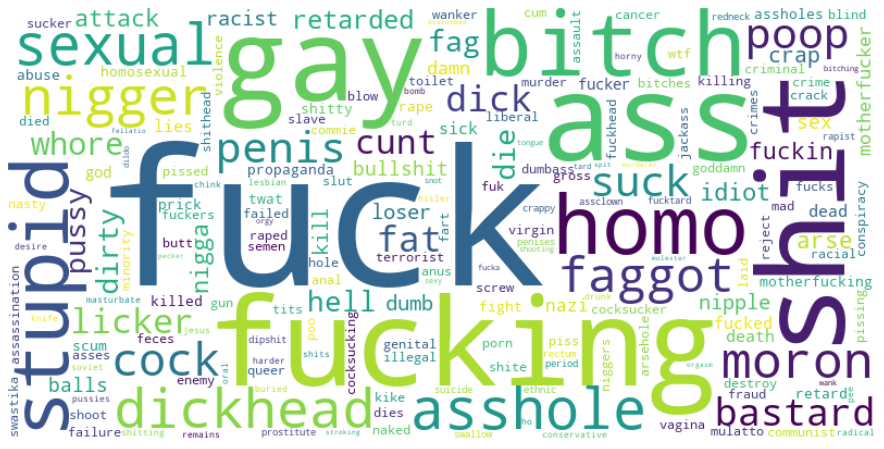

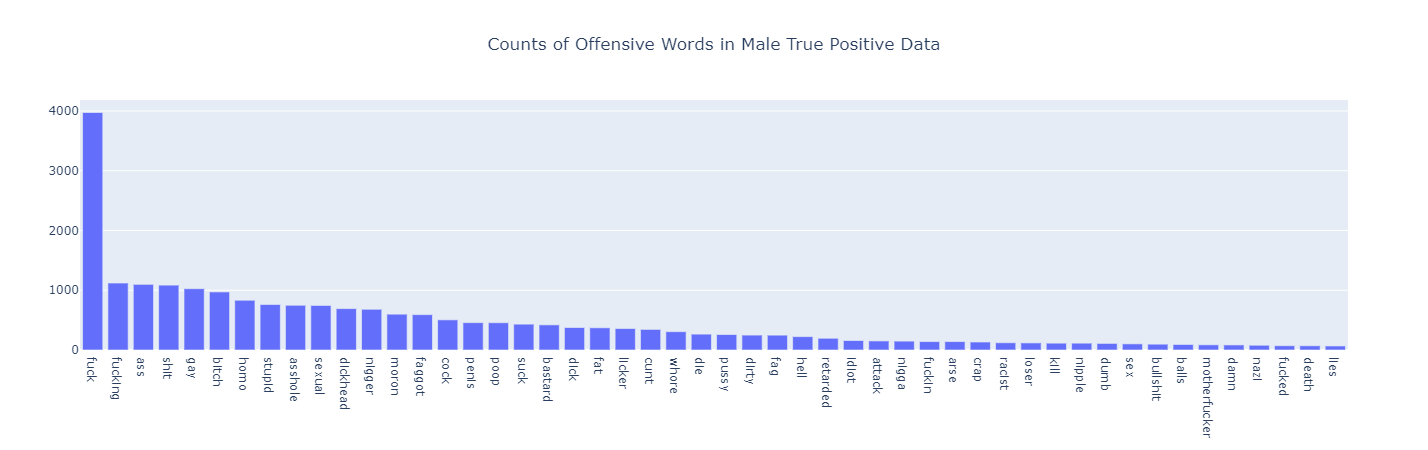

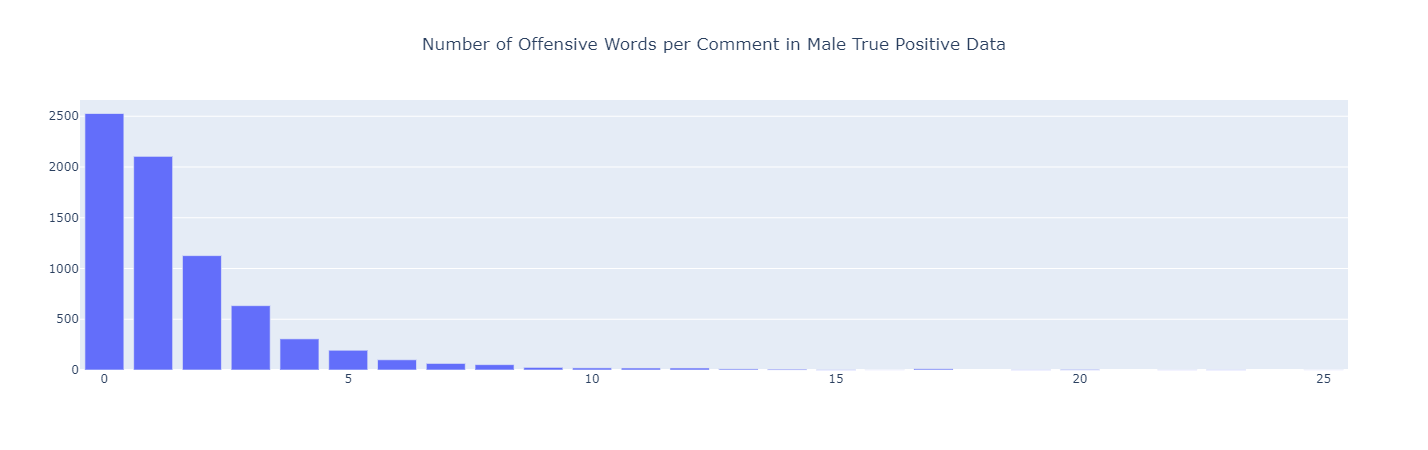

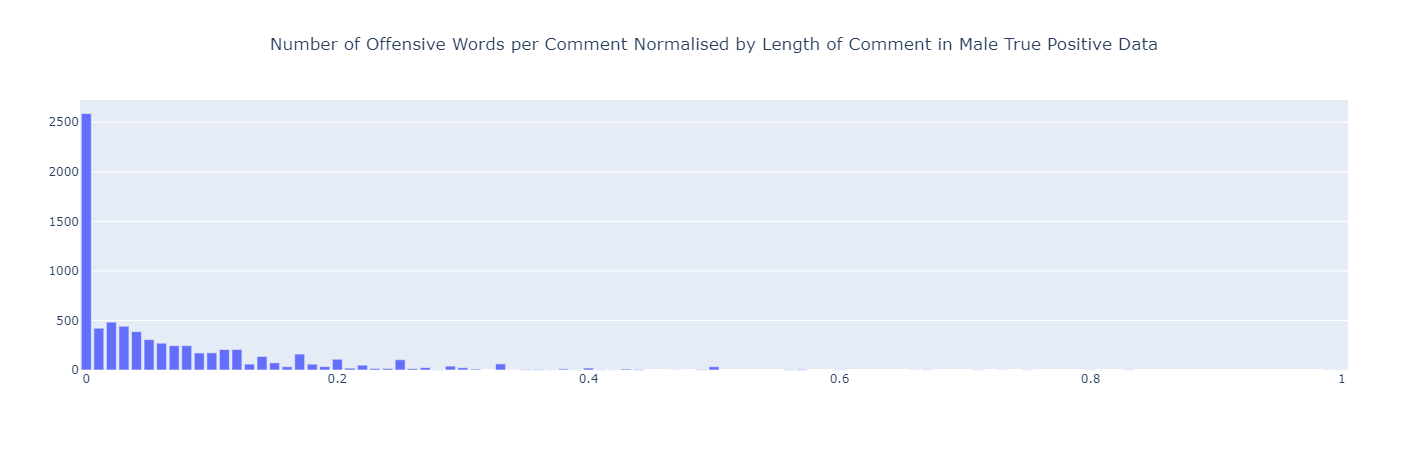

In [39]:
# Visualise results of offensive word analysis for male true positive data

print("Wordcloud of offensive words in male true positive data")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(male_true_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

male_true_dict = dict(sorted(male_true_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(male_true_dict.keys())[:50]
male_true_dict = {key:value for key, value in male_true_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(male_true_dict.keys()), y=list(male_true_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Male True Positive Data", title_x=0.5)
fig.show()

male_true_distr = dict(sorted(male_true_distr.items(), key=lambda item: item[1],reverse = True))
male_true_distr = {key:value for key, value in male_true_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(male_true_distr.keys()), y=list(male_true_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Male True Positive Data", title_x=0.5)
fig.show()

male_true_norm_distr = dict(sorted(male_true_norm_distr.items(), key=lambda item: item[1],reverse = True))
male_true_norm_distr = {key:value for key, value in male_true_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(male_true_norm_distr.keys()), y=list(male_true_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Male True Positive Data", title_x=0.5)
fig.show()

Wordcloud of offensive words in male false negative data


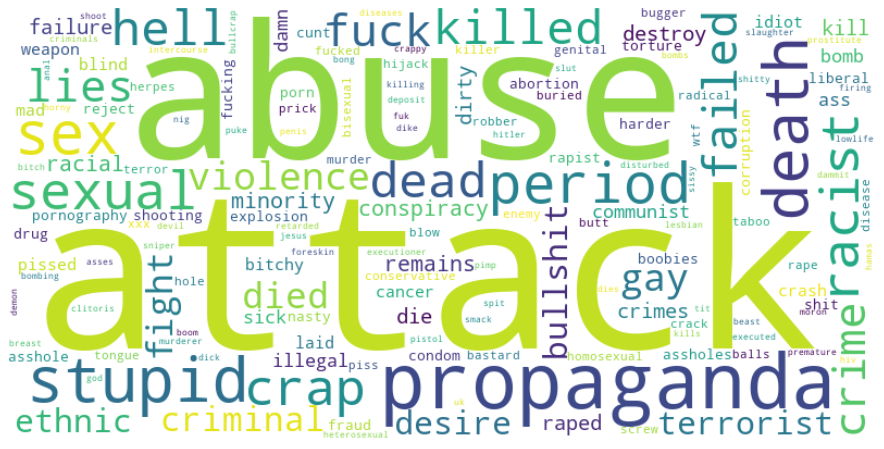

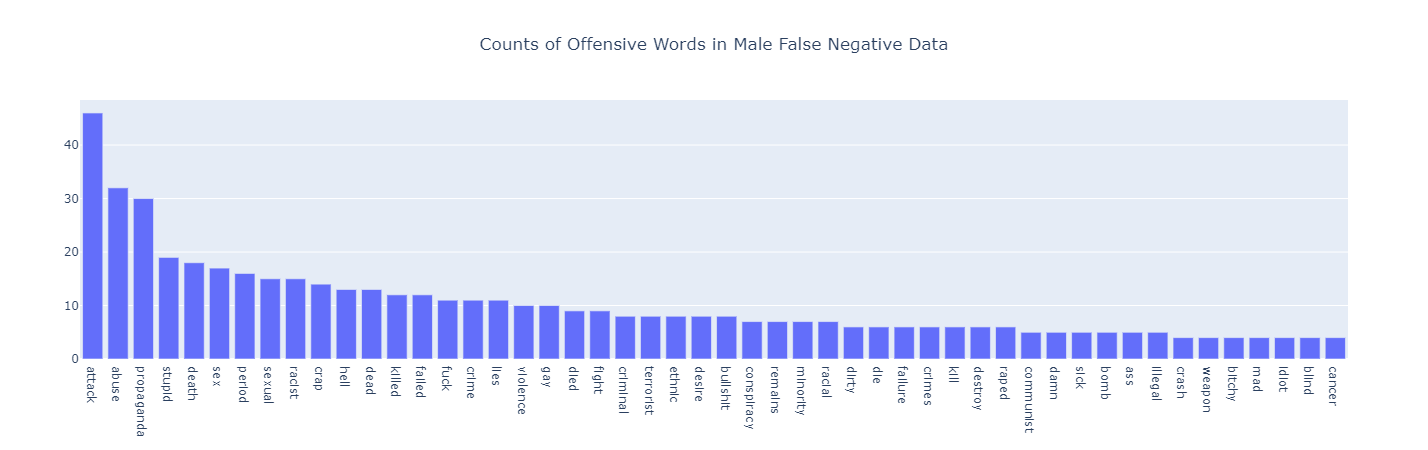

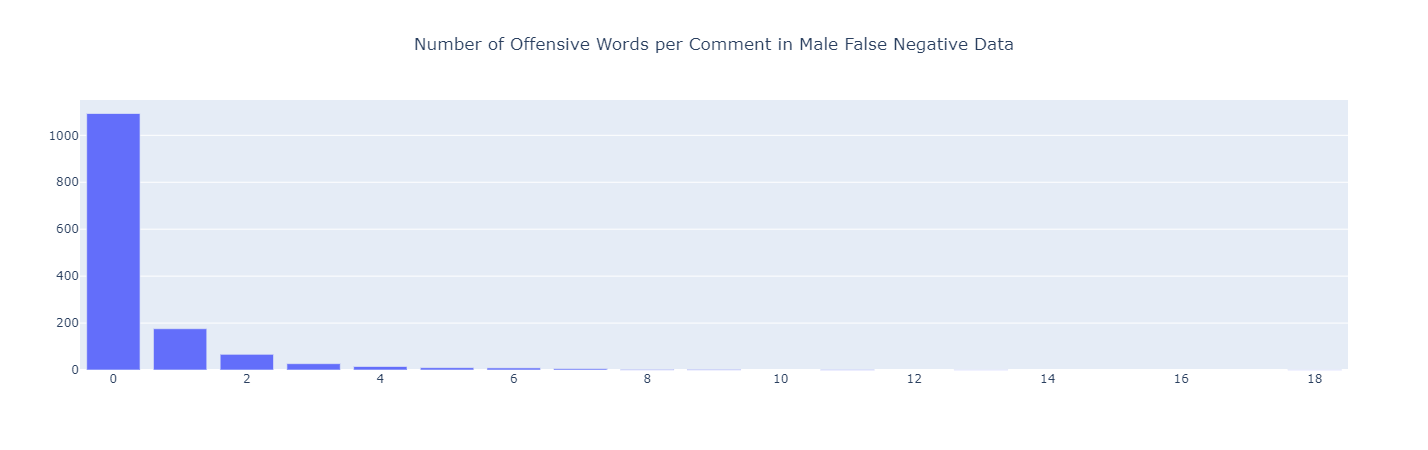

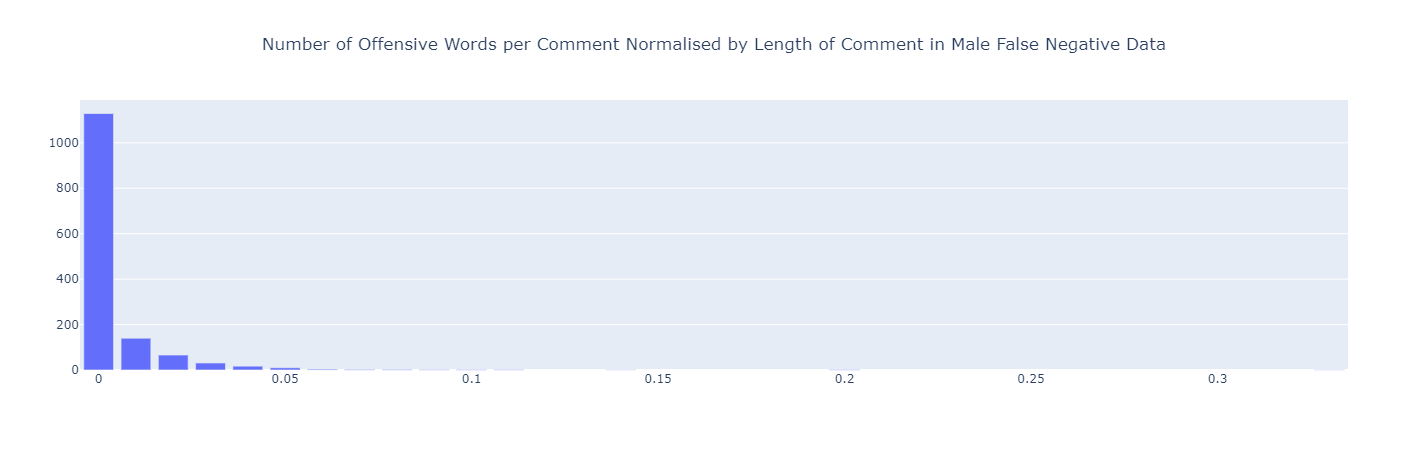

In [40]:
# Visualise results of offensive word analysis for male false negative data

print("Wordcloud of offensive words in male false negative data")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(male_false_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

male_false_dict = dict(sorted(male_false_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(male_false_dict.keys())[:50]
male_false_dict = {key:value for key, value in male_false_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(male_false_dict.keys()), y=list(male_false_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Male False Negative Data", title_x=0.5)
fig.show()

male_false_distr = dict(sorted(male_false_distr.items(), key=lambda item: item[1],reverse = True))
male_false_distr = {key:value for key, value in male_false_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(male_false_distr.keys()), y=list(male_false_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Male False Negative Data", title_x=0.5)
fig.show()

male_false_norm_distr = dict(sorted(male_false_norm_distr.items(), key=lambda item: item[1],reverse = True))
male_false_norm_distr = {key:value for key, value in male_false_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(male_false_norm_distr.keys()), y=list(male_false_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Male False Negative Data", title_x=0.5)
fig.show()

Wordcloud of offensive words in female true positive data


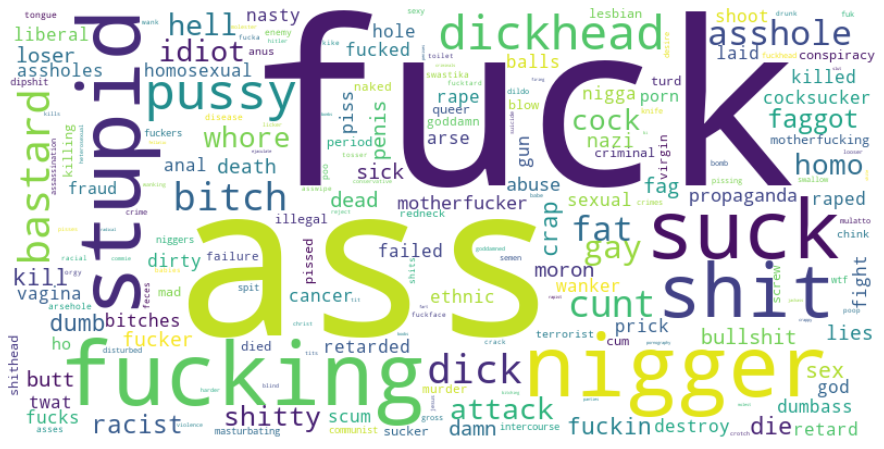

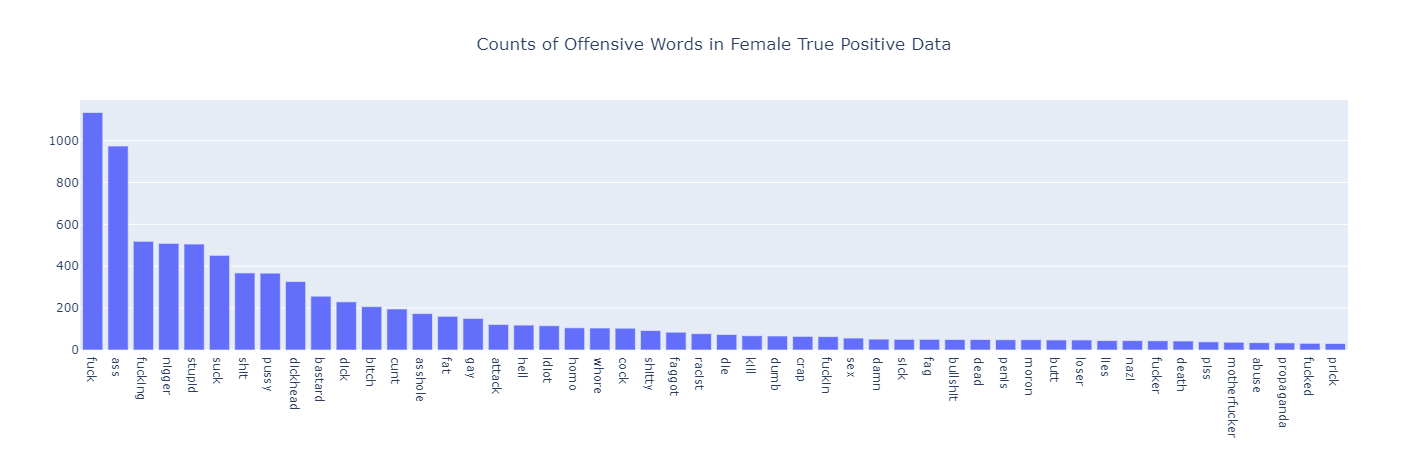

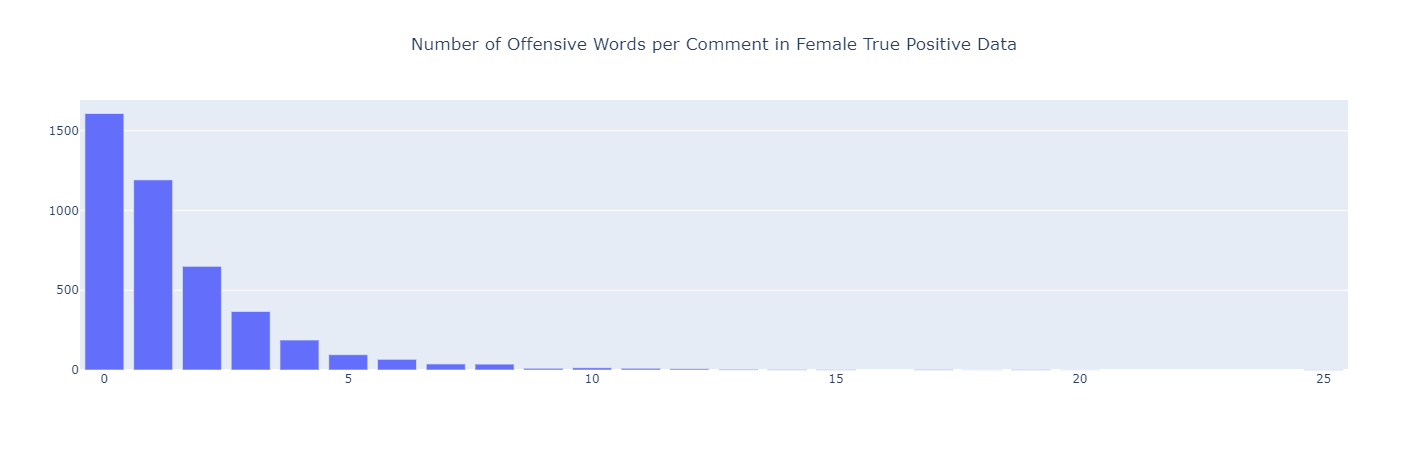

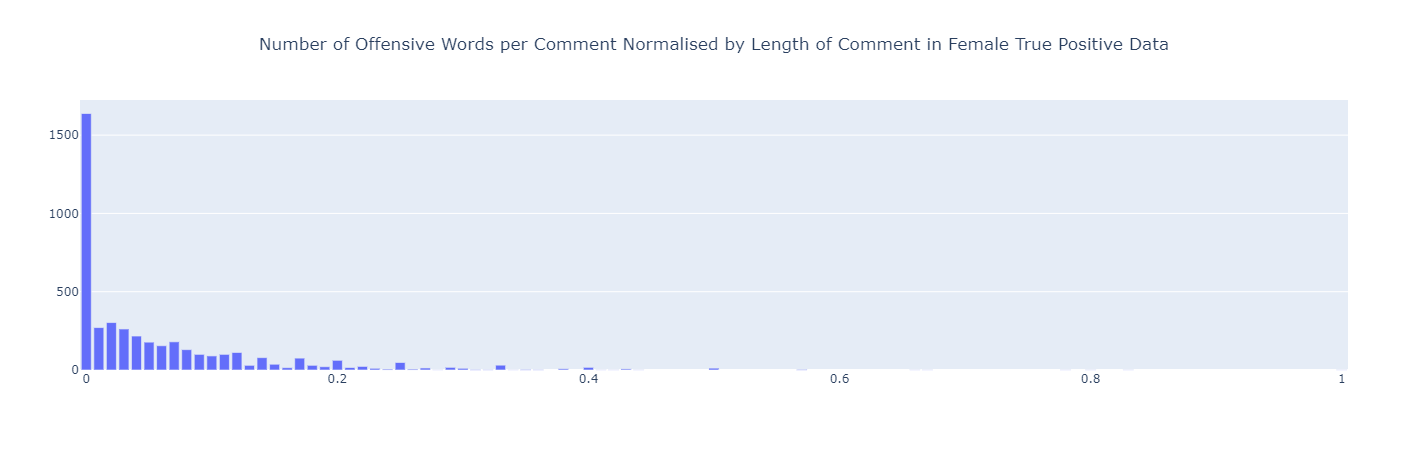

In [41]:
# Visualise results of offensive word analysis for female true positive data

print("Wordcloud of offensive words in female true positive data")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(female_true_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

female_true_dict = dict(sorted(female_true_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(female_true_dict.keys())[:50]
female_true_dict = {key:value for key, value in female_true_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(female_true_dict.keys()), y=list(female_true_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Female True Positive Data", title_x=0.5)
fig.show()

female_true_distr = dict(sorted(female_true_distr.items(), key=lambda item: item[1],reverse = True))
female_true_distr = {key:value for key, value in female_true_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(female_true_distr.keys()), y=list(female_true_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Female True Positive Data", title_x=0.5)
fig.show()

female_true_norm_distr = dict(sorted(female_true_norm_distr.items(), key=lambda item: item[1],reverse = True))
female_true_norm_distr = {key:value for key, value in female_true_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(female_true_norm_distr.keys()), y=list(female_true_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Female True Positive Data", title_x=0.5)
fig.show()

Wordcloud of offensive words in female false negative data


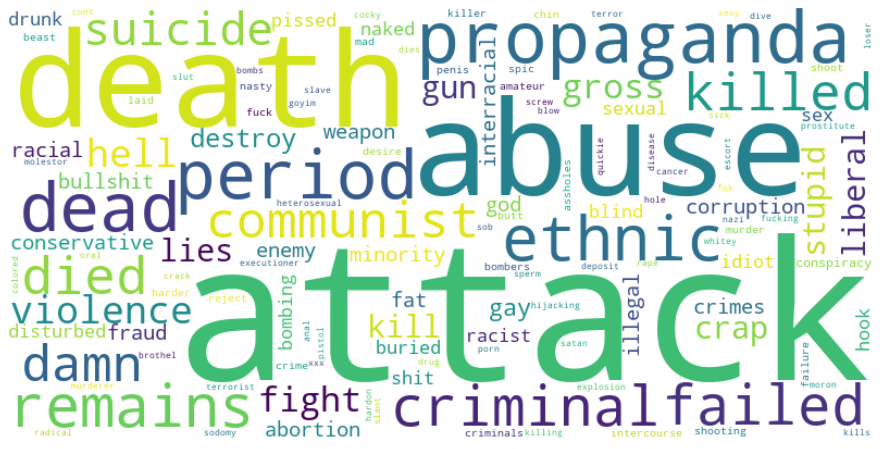

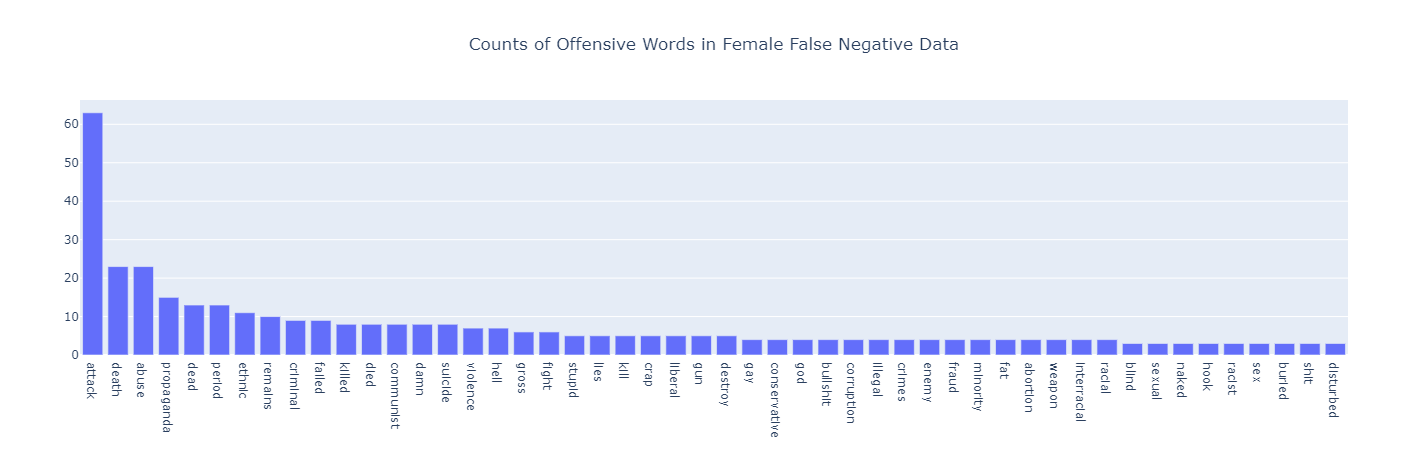

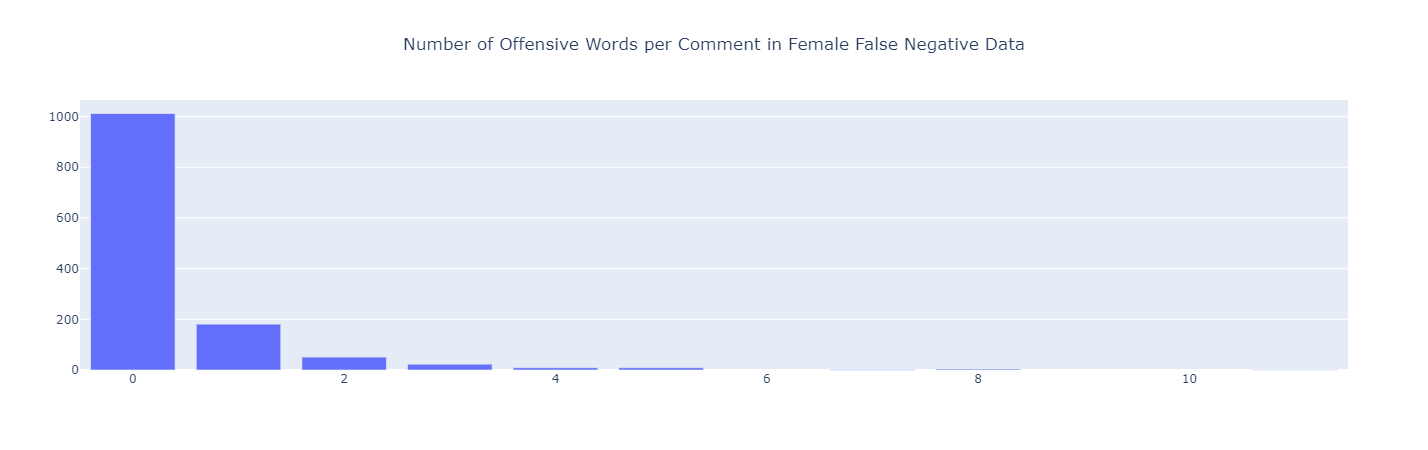

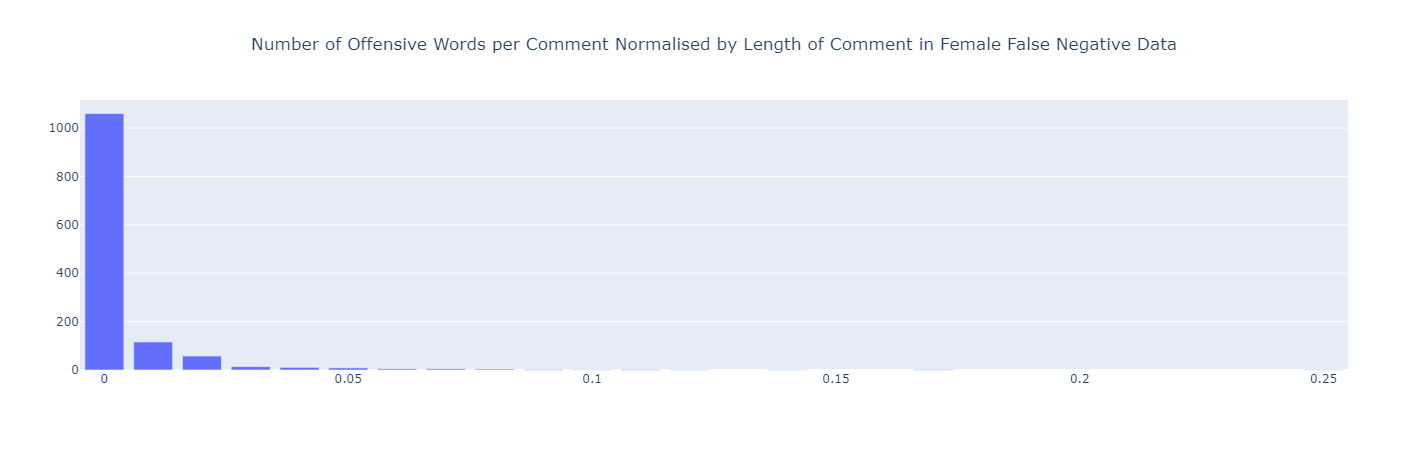

In [42]:
# Visualise results of offensive word analysis for female false negative data

print("Wordcloud of offensive words in female false negative data")
wordcloud = WordCloud(background_color="white",width=800,height=400).generate_from_frequencies(female_false_dict)
plt.figure( figsize=(16,8) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

female_false_dict = dict(sorted(female_false_dict.items(), key=lambda item: item[1],reverse = True))
keep_keys =list(female_false_dict.keys())[:50]
female_false_dict = {key:value for key, value in female_false_dict.items() if key in keep_keys}

fig = go.Figure([go.Bar(x=list(female_false_dict.keys()), y=list(female_false_dict.values()))])
fig.update_layout(title_text="Counts of Offensive Words in Female False Negative Data", title_x=0.5)
fig.show()

female_false_distr = dict(sorted(female_false_distr.items(), key=lambda item: item[1],reverse = True))
female_false_distr = {key:value for key, value in female_false_distr.items() if key <= 25}

fig = go.Figure([go.Bar(x=list(female_false_distr.keys()), y=list(female_false_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment in Female False Negative Data", title_x=0.5)
fig.show()

female_false_norm_distr = dict(sorted(female_false_norm_distr.items(), key=lambda item: item[1],reverse = True))
female_false_norm_distr = {key:value for key, value in female_false_norm_distr.items() if key <= 1}

fig = go.Figure([go.Bar(x=list(female_false_norm_distr.keys()), y=list(female_false_norm_distr.values()))])
fig.update_layout(title_text="Number of Offensive Words per Comment Normalised by Length of Comment in Female False Negative Data", title_x=0.5)
fig.show()

In [43]:
def clean_comment(comment):
    words = nltk.word_tokenize(comment)
    new_comment = []
    for word in words:
        if word not in offensive_words:
            new_comment.append(word)
    return " ".join(new_comment)

Using male toxic test data without offensive words
Number of test sentences: 8,744

Predicting labels for 8,744 test sentences...
    DONE.
Total F1: 0.813
Accuracy: 0.68


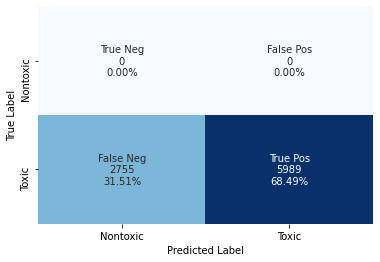

In [44]:
# Removing offensive words and retesting on same data

# Initialising
accuracies = []
    
df = male_df
print('Using male toxic test data without offensive words')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Removing offensive words from comments
new_comments = []
for comment in comments:
    new_comment = clean_comment(comment)
    new_comments.append(new_comment)
comments = new_comments

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

Using female toxic test data without offensive words
Number of test sentences: 5,630

Predicting labels for 5,630 test sentences...
    DONE.
Total F1: 0.782
Accuracy: 0.64


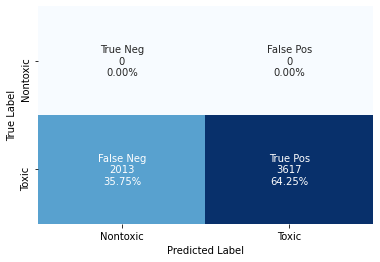

In [45]:
# Removing offensive words and retesting on same data

# Initialising
accuracies = []
    
df = female_df
print('Using female toxic test data without offensive words')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Removing offensive words from comments
new_comments = []
for comment in comments:
    new_comment = clean_comment(comment)
    new_comments.append(new_comment)
comments = new_comments

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")